In [1]:
import os
import numpy as np
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Corrected dataset paths
input_dataset_paths = {
    "F": "/kaggle/input/ecg-images/ecg_img/train/F/F",
    "N": "/kaggle/input/ecg-images/ecg_img/train/N/N",
    "Q": "/kaggle/input/ecg-images/ecg_img/train/Q/Q",
    "S": "/kaggle/input/ecg-images/ecg_img/train/S/S",
    "V": "/kaggle/input/ecg-images/ecg_img/train/V/V"
   
}

output_dataset = "/kaggle/working/dental_disease_augmented"

# Ensure the output dataset directory exists
if os.path.exists(output_dataset):
    shutil.rmtree(output_dataset)  # Remove old dataset if it exists
os.makedirs(output_dataset)

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.01,
    horizontal_flip=True
)

# Process each class folder
for class_name, class_path in tqdm(input_dataset_paths.items(), desc="Processing Classes"):
    if not os.path.exists(class_path):
        print(f"❌ Skipping {class_name}, folder not found.")
        continue
    
    # Create output directory for this class
    output_class_path = os.path.join(output_dataset, class_name)
    os.makedirs(output_class_path, exist_ok=True)
    
    # Get all image file paths
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]
    
    if not images:
        print(f"⚠️ No images found in {class_name}. Skipping.")
        continue
    
    # Generate exactly 1000 augmented images
    num_images_generated = 0
    image_index = 0
    
    with tqdm(total=1000, desc=f"Augmenting {class_name}", leave=False) as pbar:
        while num_images_generated < 1000:
            img_path = images[image_index % len(images)]  # Loop through images
            img = load_img(img_path)  # Load image
            img = img.resize((100, 100))  # Resize to 100x100
            img_array = img_to_array(img)  # Convert to array
            img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions
            
            # Generate augmented images
            aug_iter = datagen.flow(img_array, batch_size=1)
            for _ in range(min(1000 - num_images_generated, 5)):  # Generate up to 5 per iteration
                augmented_img = array_to_img(next(aug_iter)[0])  # Convert back to image
                augmented_img = augmented_img.resize((100, 100))  # Resize again
                save_path = os.path.join(output_class_path, f"aug_{num_images_generated}.png")
                augmented_img.save(save_path)  # Save augmented image
                num_images_generated += 1
                pbar.update(1)  # Update progress bar
            
            image_index += 1  # Move to the next image


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Processing Classes: 100%|██████████| 5/5 [00:22<00:00,  4.42s/it]


In [2]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def preprocess_and_save_with_subclasses2(input_dir, output_dir, target_size=(224,224)):
    """
    Preprocess images from input directory (with subclasses) and save to output directory.
    - Maintains the original folder structure (subclasses).
    - Applies image preprocessing: grayscale, CLAHE, Gaussian blur, Canny edge detection, and overlays edges in red.
    """
    # Initialize CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    list1=os.listdir(input_dir)

    for subclass in list1:
        subclass_path = os.path.join(input_dir, subclass)
        if not os.path.isdir(subclass_path):
            continue  # Skip files, only process folders
        
        # Create corresponding subclass folder in the output directory
        output_subclass_path = os.path.join(output_dir, subclass)
        if not os.path.exists(output_subclass_path):
            os.makedirs(output_subclass_path)
        
        # Process each image in the subclass folder
        for image_name in tqdm(os.listdir(subclass_path), desc=f"Processing {subclass}"):
            image_path = os.path.join(subclass_path, image_name)
            image = cv2.imread(image_path)
            
            if image is None:
                continue  # Skip invalid files
            
            # Resize image
            image = cv2.resize(image, target_size)
            
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Apply CLAHE for contrast enhancement
            clahe_enhanced = clahe.apply(gray)
            
            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(clahe_enhanced, (5, 5), 0)
            
            # Apply Canny edge detection
            edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
            
            # Create an RGB edge map (edges in red)
            edges_colored = np.zeros_like(image)  # Create a black RGB image
            edges_colored[:, :, 2] = edges  # Set red channel to edges
            
            # Overlay the edges onto the original image
            combined = cv2.addWeighted(image, 0.8, edges_colored, 0.5, 0)
            
            # Save the processed image to the corresponding output folder
            output_path = os.path.join(output_subclass_path, image_name)
            cv2.imwrite(output_path, combined)


In [3]:
# Define input and output directories
input_directory = '/kaggle/working/dental_disease_augmented'  # Contains subclass folders
output_directory = '/kaggle/working/dataset6'  # Preprocessed images will be saved here

# Run preprocessing
preprocess_and_save_with_subclasses2(input_directory, output_directory)


Processing N: 100%|██████████| 1000/1000 [00:02<00:00, 435.06it/s]


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2 
import os
import random

In [5]:
import os
import cv2
import numpy as np

def load_dataset(path_dataset, target_size=(224,224)): 
    dataset = []
    labels = []

    # Iterate over all folders in dataset_path
    for label in os.listdir(path_dataset):
        class_path = os.path.join(path_dataset, label)

        # check if the directory exists
        if os.path.isdir(class_path):
            # Initialize a counter for images in each class
            images_counter = 0
            
            # Iterate over all images in folder/class
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                # Load image with OpenCV
                image = cv2.imread(image_path)

                # Check if the image was loaded successfully
                if image is not None:
                    # Resize the image
                    image = cv2.resize(image, target_size)
                    # Get image dimensions
                    (h, w) = image.shape[:2]
                    
                    # Step 1: Apply random rotation between 0 to 5 degrees
                    angle = random.uniform(0, 5)  # Random angle between 0 and 5 degrees
                    center = (w // 2, h // 2)  # Center of the image
                    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)  # Rotation matrix
                    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
                    
                    # Step 2: Apply right-to-left flip
                    image = cv2.flip(rotated_image, 1)  # Flip horizontally
                    # Add image and label to dataset
                    dataset.append(image)
                    labels.append(label)


                else:
                    print(f"Error loading image: {image_path}")

    return np.array(dataset), np.array(labels)

dataset_path = "/kaggle/working/dataset6"
dataset, labels = load_dataset(dataset_path) 

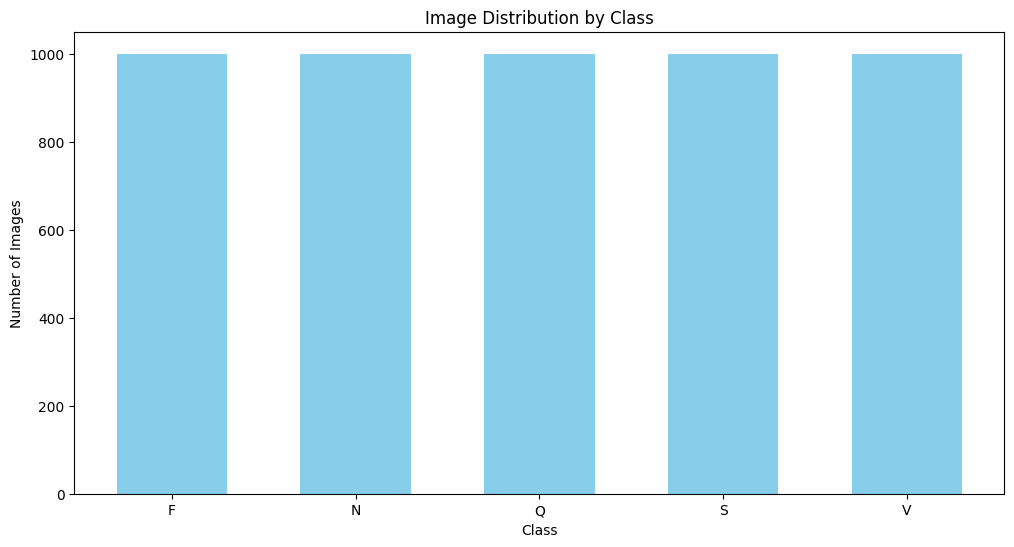

In [6]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6)) 
bars = ax.bar(class_counts.keys(), class_counts.values(), color='skyblue', width=0.6)  

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Image Distribution by Class')

plt.show()

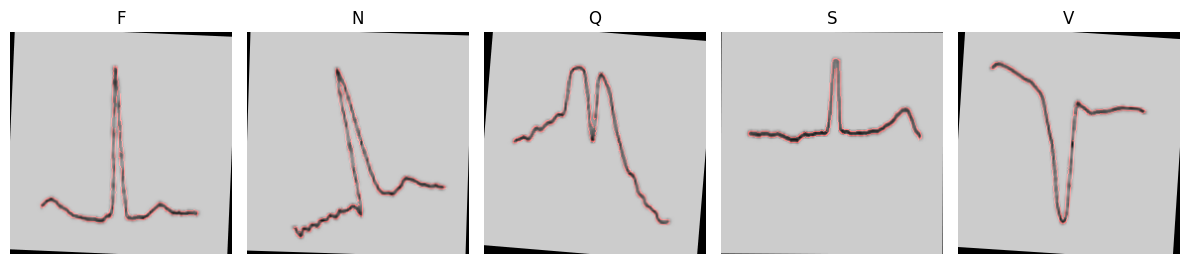

In [7]:
import random
import matplotlib.pyplot as plt

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))
    
    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels == class_name)[0]
        sample_index = random.choice(indices_class)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels into numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)



X_train, X_temp, y_train, y_temp = train_test_split(dataset, encoded_labels, test_size=0.2, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


def preprocess_image(image):
    resized_image = cv2.resize(image, (224,224))
    
    normalized_image = resized_image / 255.0
    return normalized_image


X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])
X_val = np.array([preprocess_image(image) for image in X_val])


print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4000, 224, 224, 3)
Shape of X_val: (500, 224, 224, 3)
Shape of X_test: (500, 224, 224, 3)
Shape of y_train: (4000,)
Shape of y_val: (500,)
Shape of y_test: (500,)


In [9]:
for label, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{label}: {encoded}")


F: 0
N: 1
Q: 2
S: 3
V: 4


In [10]:
!pip install efficientnet

  Obtaining dependency information for efficientnet from https://files.pythonhosted.org/packages/53/97/84f88e581d6ac86dcf1ab347c497c4c568c38784e3a2bd659b96912ab793/efficientnet-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for keras-applications<=1.0.8,>=1.0.7 from https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.9 MB/s eta 0:00:00


In [12]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Reshape, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Define number of classes
num_classes = len(np.unique(labels))

# Load EfficientNetB0 without top layers
efficientnet_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze base model (optional)
# efficientnet_model.trainable = False

# Get the EfficientNet output
x = efficientnet_model.output  # Shape: (None, 7, 7, 1280)

# Reshape for RNN: (batch_size, timesteps, features)
x = Reshape((49, 1280))(x)  # (7x7=49 timesteps, 1280 features)

# Add LSTM layer
x = LSTM(128, return_sequences=False, kernel_regularizer=l1(0.0001))(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

# Add dense layers
x = Dense(64, activation='relu', kernel_regularizer=l1(0.0001))(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu', kernel_regularizer=l1(0.0001))(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

# Final classification layer
outputs = Dense(num_classes, activation='softmax')(x)

# Build the model
model = models.Model(inputs=efficientnet_model.input, outputs=outputs)

# Compile
custom_optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])


16804768/16804768 [==============================] - 1s 0us/step
Epoch 1/50


2025-04-17 14:03:41.643028: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 62s 238ms/step - loss: 3.2718 - accuracy: 0.4753 - val_loss: 3.5450 - val_accuracy: 0.3520
Epoch 2/50
125/125 [==============================] - 26s 206ms/step - loss: 2.7202 - accuracy: 0.7350 - val_loss: 4.0652 - val_accuracy: 0.3920
Epoch 3/50
125/125 [==============================] - 26s 207ms/step - loss: 2.4029 - accuracy: 0.8425 - val_loss: 2.6640 - val_accuracy: 0.7200
Epoch 4/50
125/125 [==============================] - 26s 207ms/step - loss: 2.2061 - accuracy: 0.8950 - val_loss: 2.2522 - val_accuracy: 0.8660
Epoch 5/50
125/125 [==============================] - 26s 207ms/step - loss: 2.0217 - accuracy: 0.9315 - val_loss: 2.1038 - val_accuracy: 0.8740
Epoch 6/50
125/125 [==============================] - 26s 206ms/step - loss: 1.8455 - accuracy: 0.9548 - val_loss: 1.8653 - val_accuracy: 0.9280
Epoch 7/50
125/125 [==============================] - 26s 207ms/step - loss: 1.7163 - accuracy: 0.9613 - val_loss: 1.7390 - val_accuracy: 0.9

In [18]:
# Save the weights of the model to a file
model.save_weights('rnn_arythmis.h5')

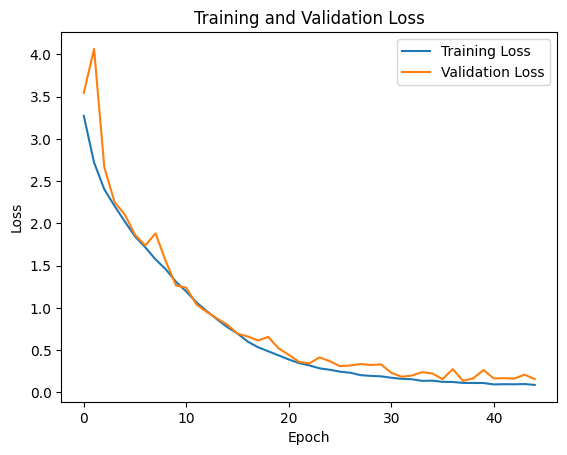

In [14]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

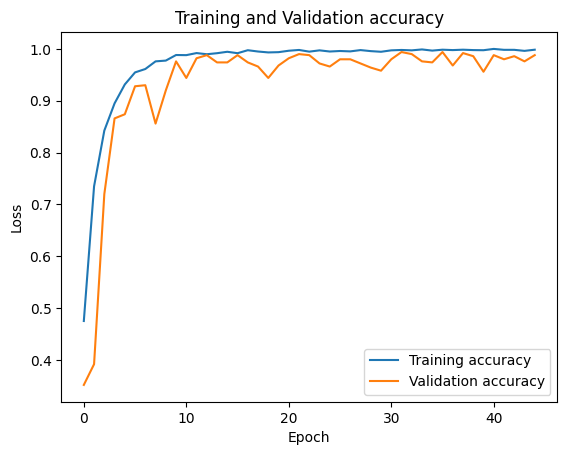

In [15]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 [==============================] - 2s 38ms/step
Test Accuracy: 0.9900


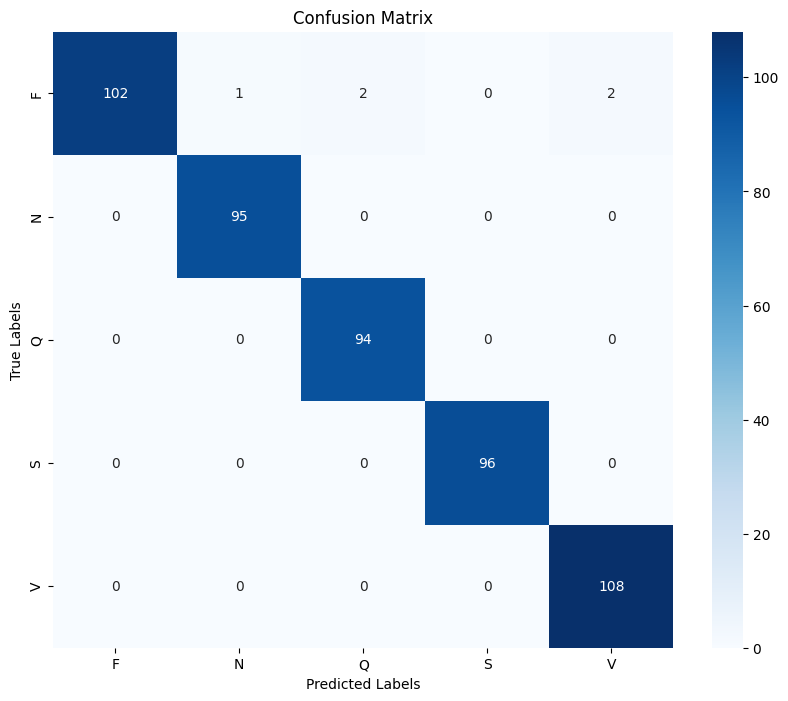

Classification Report:
              precision    recall  f1-score   support

           F     1.0000    0.9533    0.9761       107
           N     0.9896    1.0000    0.9948        95
           Q     0.9792    1.0000    0.9895        94
           S     1.0000    1.0000    1.0000        96
           V     0.9818    1.0000    0.9908       108

    accuracy                         0.9900       500
   macro avg     0.9901    0.9907    0.9902       500
weighted avg     0.9902    0.9900    0.9899       500



In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and predicted classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = y_test

# Calculate test accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_, digits=4))


1/1 [==============================] - 0s 386ms/step


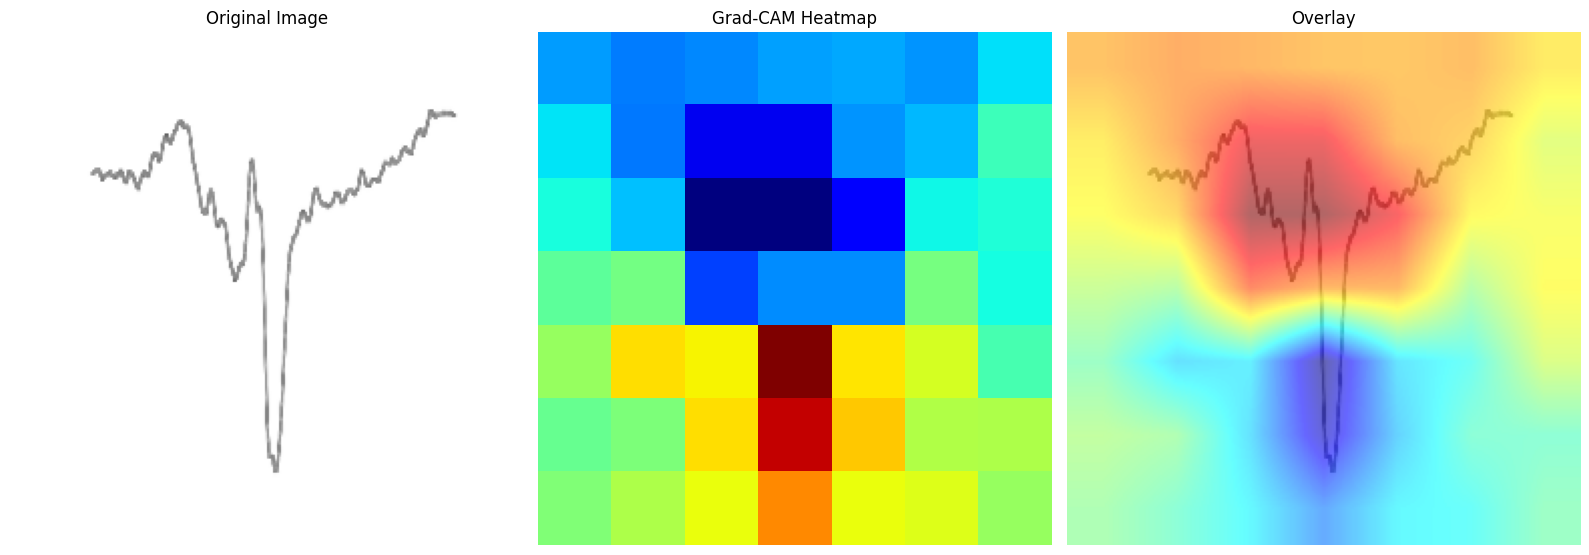

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

def generate_gradcam_heatmap(model, image, class_idx, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(guided_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap_on_image(heatmap, original_image, alpha=0.6, colormap=cv2.COLORMAP_JET):
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed_image

# Load image
image_path ="/kaggle/input/ecg-images/ecg_img/train/F/F/Ffig_1.png"
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(original_image, (224, 224)) / 255.0

# Predict class
class_idx = np.argmax(model.predict(np.expand_dims(image, axis=0)))

# Generate Grad-CAM
heatmap = generate_gradcam_heatmap(model, image, class_idx, last_conv_layer_name='top_conv')

# Overlay
overlayed_image = overlay_heatmap_on_image(heatmap, original_image)

# Display
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlayed_image)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
